## Installs

In [11]:
%pip install keras
%pip install tensorflow
%pip install matplotlib
%pip install scikit-learn
%pip install pillow
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Raviv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Raviv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Raviv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Raviv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Raviv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Raviv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


## Imports


In [26]:
import os
import keras
import random
import numpy as np
import tensorflow as tf
from os import path
from matplotlib import pyplot as plt
from keras import layers
from keras.layers import RandomBrightness, RandomRotation, RandomZoom, RandomContrast
from keras.callbacks import EarlyStopping
from utils import load_data, add_samples_to_validation, shuffle_dataset

## Loading the data

In [13]:
all_labels = ['NORMAL', 'bacteria', 'virus']
#base_dir = "/Users/neriya.shulman/content/chest_xray"
base_dir = os.path.join(os.getcwd(), "chest_xray")

In [14]:
img_height = 150
img_width = 150
print("Image size: ", img_height, "x", img_width)

Image size:  150 x 150


In [15]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical

In [16]:
def get_label(dir_name, file_name, file_labels=[]):
    for label in file_labels:
        if label in file_name:
            return label
    return dir_name

def load_data_from_path(base_dir, img_height, img_width, file_labels=[]):
    dataset = []
    labels = []
    img_size = (img_height, img_width)
    dir_names = os.path.basename(base_dir)
    for file in os.scandir(base_dir):
        if file.name == '.DS_Store':
            continue
        if file.is_dir():
            dir_images, dir_labels = load_data_from_path(file.path, img_height, img_width, file_labels)
            dataset.extend(dir_images)
            labels.extend(dir_labels)
        else:
            img = img_to_array(load_img(file.path, target_size=img_size, color_mode='grayscale'))
            dataset.append(img)
            labels.append(get_label(dir_names, file.name, file_labels))
    dataset = np.array(dataset, dtype='float32')
    labels = np.array(labels)
    return dataset, labels

def load_data(path, img_height, img_width, all_labels, file_labels=[]):
    dataset, labels = load_data_from_path(path, img_height, img_width, file_labels)
    dataset /= 255 # rescale to be between 0 and 1
    labels = np.array([all_labels.index(label) for label in labels]) # one-hot encoding
    if len(all_labels) > 2:
        labels = to_categorical(labels, len(all_labels))
    else:
        labels = np.expand_dims(labels, -1)
    return dataset, labels

def shuffle_dataset(dataset, labels):
    indices = np.arange(dataset.shape[0])
    np.random.shuffle(indices)
    return dataset[indices], labels[indices]

In [17]:
def balance_data(normal_data, pneum_data):
    multiply_by = round(len(pneum_data) / len(normal_data))
    return np.concatenate([normal_data for _ in range(multiply_by)], axis=0)

def get_balanced_data(base_dir, file_labels=[]):
    normal_train_set, normal_train_labels = load_data(path.join(base_dir, "NORMAL"), img_height, img_width, all_labels)
    pneum_train_set, pneum_train_labels = load_data(path.join(base_dir, "PNEUMONIA"), img_height, img_width, all_labels, file_labels=file_labels)
    normal_train_set = balance_data(normal_train_set, pneum_train_set)
    normal_train_labels = balance_data(normal_train_labels, pneum_train_labels)
    
    train_set = np.concatenate([normal_train_set, pneum_train_set], axis=0)
    train_labels = np.concatenate([normal_train_labels, pneum_train_labels], axis=0)
    return train_set, train_labels

In [18]:
all_labels = ['NORMAL', 'bacteria', 'virus']
train_path = os.path.join(base_dir, "train")
train_set, train_labels = get_balanced_data(train_path, file_labels=['bacteria', 'virus'])
train_set.shape, train_labels.shape

((7098, 150, 150, 1), (7098, 3))

In [19]:
val_path = path.join(base_dir, "val/")
validation_set, validation_labels = load_data(val_path, img_height, img_width, all_labels, file_labels=['bacteria', 'virus'])
validation_set.shape, validation_labels.shape

((416, 150, 150, 1), (416, 3))

In [20]:
test_path = path.join(base_dir, "test/")
test_set, test_labels = load_data(test_path, img_height, img_width, all_labels, file_labels=['bacteria', 'virus'])
test_set.shape, test_labels.shape

((624, 150, 150, 1), (624, 3))

In [21]:
print('Number of classes: ', len(all_labels))
print('Number of total samples: ', len(train_set))

Number of classes:  3
Number of total samples:  7098


In [22]:
#orig_train_set, orig_train_labels, train_file_names = load_data(path.join(base_dir, "train"), img_size, all_labels)
#orig_validation_set, orig_validation_labels, _ = load_data(path.join(base_dir, "val"), img_size, all_labels)
#test_set, test_labels, _ = load_data(path.join(base_dir, "test"), img_size, all_labels)

## Data preprocessing

Normalization

In [23]:
#orig_train_set /= 255
#orig_validation_set /= 255
#test_set /= 255

Increase validation set

In [24]:
#print('validation set size before moving from the train: ', len(orig_validation_set))
#
#num_to_move = 200
#normal_indexes = [i for i, label in enumerate(orig_train_labels.reshape(-1)) if label == 0]
#bacteria_indexes = [i for i, file in enumerate(train_file_names.reshape(-1)) if 'bacteria' in file]
#virus_indexes = [i for i, file in enumerate(train_file_names.reshape(-1)) if 'virus' in file]
#
#new_indexes = np.concatenate((normal_indexes[:num_to_move], bacteria_indexes[:num_to_move//2], virus_indexes[:num_to_move//2]), axis=0)
#validation_set = np.concatenate((orig_validation_set, orig_train_set[new_indexes]), axis=0)
#validation_labels = np.concatenate((orig_validation_labels, orig_train_labels[new_indexes]), axis=0)
#
#train_set = np.delete(orig_train_set, new_indexes, axis=0)
#train_labels = np.delete(orig_train_labels, new_indexes, axis=0)
#
#print('validation set size after moving: ', len(validation_set))

Balance the training data

Number of images in training set:  7098
Number of Normal images:  3423
Number of bacteria images:  2430
Number of virus images:  1245
Ratio between classes: 48:34:18


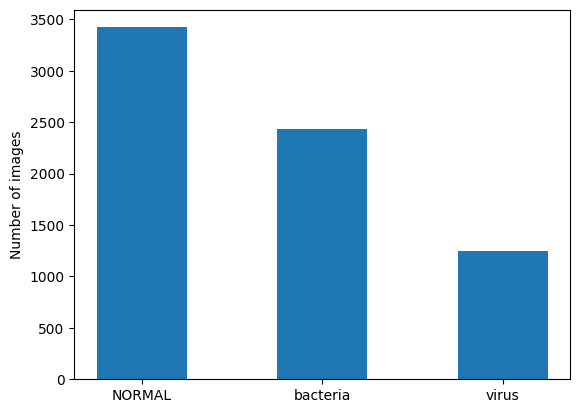

In [27]:
normal_train_data = train_set[train_labels[:, 0] == 1] 
bacteria_train_data = train_set[train_labels[:, 1] == 1]
virus_train_data = train_set[train_labels[:, 2] == 1]

print('Number of images in training set: ', len(train_set))
print('Number of Normal images: ', len(normal_train_data))
print('Number of bacteria images: ', len(bacteria_train_data))
print('Number of virus images: ', len(virus_train_data))
ratio_normal = round(len(normal_train_data)/len(train_set)*100)
ratio_bacteria = round(len(bacteria_train_data)/len(train_set)*100)
ratio_virus = round(len(virus_train_data)/len(train_set)*100)
print(f'Ratio between classes: {ratio_normal}:{ratio_bacteria}:{ratio_virus}')

arr = np.array([{(1., 0., 0.,):'NORMAL', (0., 1., 0.,):'bacteria', (0., 0., 1.,):'virus'}[tuple(x)] for x in train_labels])
#print(arr)
nc = len(set(arr)) 
plt.hist(arr, bins=3, rwidth=0.5)
plt.ylabel('Number of images')
plt.xticks(np.linspace(0, nc-1, 2*nc+1)[1::2], ['NORMAL', 'bacteria', 'virus'])
plt.show()

Shuffling

In [28]:
def shuffle_dataset(dataset, labels):
    indices = np.arange(dataset.shape[0])
    np.random.shuffle(indices)
    return dataset[indices], labels[indices]

train_set, train_labels = shuffle_dataset(train_set, train_labels)

## The model

In [29]:
max_epochs = 50
batch_size = 64
learning_rate=0.001
print("Batch size: ", batch_size)
print('Number of training batches: ', len(train_set)//batch_size)

Batch size:  64
Number of training batches:  110


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(img_height, img_width, 1)),
        RandomRotation(0.35),
        RandomZoom(0.1),
        RandomBrightness(0.02, value_range=(0,1)),
        RandomContrast(0.02),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(name='flatten'),
        layers.Dense(units=1024, activation='relu'),
        layers.Dense(units=526, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(units=256, activation='relu'),
        layers.Dense(units=128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(all_labels), activation='softmax'),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "recall", "precision"])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(train_set, train_labels, epochs=max_epochs, batch_size=batch_size,
        validation_data=(validation_set, validation_labels), callbacks=[early_stopping])


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4660 - loss: 1.0470 - precision: 0.5348 - recall: 0.1254 - val_accuracy: 0.5649 - val_loss: 1.0812 - val_precision: 0.7487 - val_recall: 0.3582
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.5928 - loss: 0.8974 - precision: 0.7569 - recall: 0.3821 - val_accuracy: 0.6298 - val_loss: 1.2757 - val_precision: 0.6511 - val_recall: 0.5697
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7474 - loss: 0.6202 - precision: 0.7859 - recall: 0.6826 - val_accuracy: 0.6851 - val_loss: 0.8502 - val_precision: 0.7106 - val_recall: 0.6611
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.7713 - loss: 0.5570 - precision: 0.7969 - recall: 0.7346 - val_accuracy: 0.6875 - val_loss: 0.7508 - val_precision: 0.7255 - val_recall: 0.6418
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7745 - loss: 0.5246 - precision: 0.8140 - recall: 0.7325 - val_accuracy: 0.7212 - val_los

In [ ]:
print(model.summary())

Show the metrics of the model

In [ ]:
score = model.evaluate(test_set, test_labels, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])


In [ ]:
model.save('model_q1_b.keras')

In [ ]:
# result = model.predict(test_set)
# pred_test_labels = np.where(result > 0.5, 1, 0)
# conf_matrix = confusion_matrix(test_labels.squeeze(), pred_test_labels.squeeze())

# plt.figure(figsize=(6, 4))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.title('Confusion Matrix')
# plt.show()

save the model